In this notebook, I test out several different ML algorithms in an attempt to create a prediction model for Enron Scandal POIs. 

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: initial feature selection
# 3/10 based on visualizations, removed email_address, loan_advances, director_fees, 
# restricted_stock_deferred, other

features_list1 = ['poi', 'salary', 'deferral_payments', 'total_payments', 'bonus', 'director_fees', 'other',
                 'deferred_income', 'total_stock_value', 'exercised_stock_options','restricted_stock_deferred',
                 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages','from_messages', 
                 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi',
                 'total_salary_ratio', 'payments_plus_stock']
                 


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict1 = pickle.load(data_file)

### Task 2: Remove outlier identified from earlier visualizatoin
data_dict1.pop('TOTAL')
data_dict1.pop('THE TRAVEL AGENCY IN THE PARK')


### Task 3: Create new features to test
# total_salary_ratio is ratio of total_payements which includes bonus, long term incentive, and other payments 
# to employees salary
# payments_plus_stock is total_payments added to total_stock_value

for name in data_dict1:
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['salary'] != 'NaN':
        data_dict1[name]['total_salary_ratio'] = (data_dict1[name]['total_payments']*1./data_dict1[name]['salary'])
    else:
        data_dict1[name]['total_salary_ratio'] = 'NaN'
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['total_stock_value'] != 'NaN':
        data_dict1[name]['payments_plus_stock'] = data_dict1[name]['total_payments'] \
        + data_dict1[name]['total_stock_value']
    else:
        data_dict1[name]['payments_plus_stock'] = 'NaN'
           
                 
### Store to my_dataset for easy export below.
my_dataset1 = data_dict1


### Extract features and labels from dataset for local testing
# featureFormat converts dictionary to numpy array of features
# also removes NaN and converts to 0.0

data1 = featureFormat(my_dataset1, features_list1, sort_keys = True)



C:\Users\Scott\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

# for a given numpy array, splits out the first feature for prediction (in this case, 'poi')
# return target and features as seperate lists
labels, features = targetFeatureSplit(data1)


### split into training and testing sets
# due to small dataset, I'm not holding out any test set and will train in entirety of data
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0, random_state=42)

### Try using SelectKBest to find best features in univariate testing (does not look at feature interactions)
from sklearn.feature_selection import SelectKBest, f_classif

print "initial # of features = " + str(len(features_list1))

skb = SelectKBest(k = 'all')
best_features = skb.fit_transform(features_train, labels_train)


# Get SelectKBest scores, rounded to 2 decimal places, name them "feature_scores"
feature_scores = ['%.2f' % elem for elem in skb.scores_ ]
# Get SelectKBest pvalues, rounded to 3 decimal places, name them "feature_scores_pvalues"
feature_scores_pvalues = ['%.3f' % elem for elem in  skb.pvalues_ ]
# Get SelectKBest feature names, whose indices are stored in 'skb.get_support',
# create a tuple of feature names, scores and pvalues, name it "features_selected_tuple"
features_selected_tuple=[(features_list1[i+1], feature_scores[i], 
                          feature_scores_pvalues[i]) for i in skb.get_support(indices=True)]

# Sort the tuple by score, in reverse order
features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

# Print
print ' '
print 'Selected Features, Scores, P-Values'
print features_selected_tuple

initial # of features = 21
 
Selected Features, Scores, P-Values
[('exercised_stock_options', '24.82', '0.000'), ('total_stock_value', '24.18', '0.000'), ('bonus', '20.79', '0.000'), ('salary', '18.29', '0.000'), ('payments_plus_stock', '17.81', '0.000'), ('deferred_income', '11.46', '0.001'), ('long_term_incentive', '9.92', '0.002'), ('restricted_stock', '9.21', '0.003'), ('total_payments', '8.77', '0.004'), ('shared_receipt_with_poi', '8.59', '0.004'), ('from_poi_to_this_person', '5.24', '0.024'), ('other', '4.19', '0.043'), ('from_this_person_to_poi', '2.38', '0.125'), ('director_fees', '2.13', '0.147'), ('director_fees', '2.13', '0.147'), ('to_messages', '1.65', '0.202'), ('deferral_payments', '0.22', '0.636'), ('from_messages', '0.17', '0.681'), ('restricted_stock_deferred', '0.07', '0.798'), ('total_salary_ratio', '0.05', '0.819')]


In [3]:
# fist try with full feature set

### Store to my_dataset for easy export below.
my_dataset1 = data_dict1

### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset1, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data1)


In [4]:
### Task 4: Trying variety of classifiers

from tester import main #import scripts from tester.py

'''
    running main() fom tester.py tests the classifier using cross fold validation (1000 folds)
    uses StratifiedShuffleSplit() from sklearn.cross_validation
    since our dataset is small and unbalanced (many more non-POIs than POIs, )
    The performance measure reported by k-fold cross-validation is then the average 
    of the values computed in the loop.
'''

# Naive Bayes

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

GaussianNB(priors=None)
	Accuracy: 0.37680	Precision: 0.15912	Recall: 0.85750	F1: 0.26843	F2: 0.45665
	Total predictions: 15000	True positives: 1715	False positives: 9063	False negatives:  285	True negatives: 3937



In [5]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=2)
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.79080	Precision: 0.23923	Recall: 0.26100	F1: 0.24964	F2: 0.25633
	Total predictions: 15000	True positives:  522	False positives: 1660	False negatives: 1478	True negatives: 11340



In [6]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=5)
# note that n_estmiators is the number of trees in the forest
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.84347	Precision: 0.34520	Recall: 0.19400	F1: 0.24840	F2: 0.21263
	Total predictions: 15000	True positives:  388	False positives:  736	False negatives: 1612	True negatives: 12264



In [7]:
# reduce features manually to those with p-values < .01 from SelectKBest
features_list1 = ['poi', 'bonus', 'salary', 'payments_plus_stock', 'shared_receipt_with_poi', 'total_stock_value', 
                  'exercised_stock_options', 'total_payments','deferred_income', 'restricted_stock', 
                  'long_term_incentive']


In [8]:
### Store to my_dataset for easy export below.
my_dataset1 = data_dict1

### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset1, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data1)

In [9]:
# try NB again
clf = GaussianNB()
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()


GaussianNB(priors=None)
	Accuracy: 0.84380	Precision: 0.40058	Recall: 0.34550	F1: 0.37101	F2: 0.35527
	Total predictions: 15000	True positives:  691	False positives: 1034	False negatives: 1309	True negatives: 11966



In [10]:
# decision tree
clf = tree.DecisionTreeClassifier(min_samples_split=2)
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.81120	Precision: 0.29032	Recall: 0.28800	F1: 0.28916	F2: 0.28846
	Total predictions: 15000	True positives:  576	False positives: 1408	False negatives: 1424	True negatives: 11592



In [11]:
#try randomforest
clf = RandomForestClassifier(n_estimators=5)
# note that n_estmiators is the number of trees in the forest
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.84500	Precision: 0.36691	Recall: 0.22400	F1: 0.27817	F2: 0.24292
	Total predictions: 15000	True positives:  448	False positives:  773	False negatives: 1552	True negatives: 12227



In [12]:
clf = RandomForestClassifier(n_estimators=10)
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85393	Precision: 0.38077	Recall: 0.15250	F1: 0.21778	F2: 0.17328
	Total predictions: 15000	True positives:  305	False positives:  496	False negatives: 1695	True negatives: 12504



In [13]:
clf = RandomForestClassifier(n_estimators=15)
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85413	Precision: 0.40249	Recall: 0.19400	F1: 0.26181	F2: 0.21642
	Total predictions: 15000	True positives:  388	False positives:  576	False negatives: 1612	True negatives: 12424



In [14]:
#manually reduce feature set further to 2 features

features_list1 = ['poi', 'bonus', 'salary']

### Store to my_dataset for easy export below.
my_dataset1 = data_dict1

### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset1, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data1)


In [15]:
clf = RandomForestClassifier(n_estimators=15)
dump_classifier_and_data(clf, my_dataset1, features_list1)
main()


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.74450	Precision: 0.30221	Recall: 0.21200	F1: 0.24919	F2: 0.22546
	Total predictions: 10000	True positives:  424	False positives:  979	False negatives: 1576	True negatives: 7021



Interestingly, the model with the best performance of the ones tested thus far is the simple Gaussian Naive Bayes with default parameters. Even though that algorithm is hitting my desired benchmarks of .30 precision and .30 recall, more work can certainly be done to optimize and tune various algorithms for better performance.

In this particular use-case, while accuracy is always important, I prioritize recall since that is the ratio of true positives to all positives. That is, it is the algorithm's ability to pick up a POI if the person is indeed a POI. I would rather sacrifice precision for recall in this instance since our fraud detector would only be a first line of idenfification of possible fraud that could then be supplemented by in depth human investigation. In a way, I wish to algorithmically cast a wider net by incrasing recall. 

Next steps I would like to pursue:
  * continue testing/tuning with Naive Bayes, Decision Tree, and RandomForest parameters to boost recall
  * learn how to visualize classificaiton outputs (decision surface splits, etc)
  * test using feature scaling and Principal Components Analysis (PCA) on Naive Bayes
  * implement a pipeline to better automate workflow and prevent risk of information leakage
  * test using GridsearchCV to systematically seek optimum features


In [16]:
# go back to original dataset minus obvious ones to omit

features_list1 = ['poi', 'salary', 'deferral_payments', 'total_payments', 'bonus', 'director_fees', 'other',
                 'deferred_income', 'total_stock_value', 'exercised_stock_options','restricted_stock_deferred',
                 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages','from_messages', 
                 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi',
                 'total_salary_ratio', 'payments_plus_stock']
### Store to my_dataset for easy export below.
my_dataset1 = data_dict1

### Extract features and labels from dataset for local testing
data1 = featureFormat(my_dataset1, features_list1, sort_keys = True)
labels, features = targetFeatureSplit(data1)

In [17]:
# set up various pipeline objects
from pprint import pprint
from sklearn.model_selection import GridSearchCV # updated based on scikit-learn 0.18.1
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from datetime import datetime as dt


kbest = SelectKBest(f_classif)
pca = PCA()
scaler = preprocessing.StandardScaler()
clf_GNB = GaussianNB()

# read that I should normalize before PCA so I put normalizer before PCA in pipeline
# http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

pipe_nb = Pipeline(steps =[
    ('kbest', kbest),
    ('std_scale', scaler),    
    ('PCA', pca),   
    ('nb_clf', clf_GNB)    
    ])

parameters_nb = {"PCA__n_components":[2,4,6], "PCA__whiten": [True],
              "kbest__k":[6,8,10,12,'all']}

In [18]:
# use pipeline in GridSearchCV

if __name__ == "__main__":
    
    # initialize grid search
    grid_search = GridSearchCV(pipe_nb, parameters_nb, n_jobs = -1, verbose = 1, scoring = "roc_auc")
 
    print("\nPerforming grid search...")
    print("pipeline:", [name for name, _ in pipe_nb.steps])
    print("parameters:")
    #pprint(parameters)
    t0 = dt.now()
    grid_search.fit(features_train, labels_train)
    print("done in {}\n".format(dt.now() - t0))
    print("\nBest score: {:0.3f}".format(grid_search.best_score_))
    print("\nBest parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters_nb.keys()):
        print("\t{}: {}".format(param_name, best_parameters[param_name]))


Performing grid search...
('pipeline:', ['kbest', 'std_scale', 'PCA', 'nb_clf'])
parameters:
Fitting 3 folds for each of 15 candidates, totalling 45 fits
done in 0:00:02.670000


Best score: 0.797

Best parameters set:
	PCA__n_components: 4
	PCA__whiten: True
	kbest__k: 12


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


In [19]:
features_selected_bool = grid_search.best_estimator_.named_steps['kbest'].get_support()
features_selected_list = [x for x, y in zip(features_list1[1:], features_selected_bool) if y]

In [20]:
features_selected_list

['salary',
 'total_payments',
 'bonus',
 'other',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'payments_plus_stock']

In [21]:
best_clf = grid_search.best_estimator_.fit(features_train, labels_train)

In [22]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict1 = pickle.load(data_file)

    
    
### Task 2: Remove outlier identified from earlier visualizatoin
data_dict1.pop('TOTAL')
data_dict1.pop('THE TRAVEL AGENCY IN THE PARK')


# add custom features
for name in data_dict1:
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['salary'] != 'NaN':
        data_dict1[name]['total_salary_ratio'] = (data_dict1[name]['total_payments']*1./data_dict1[name]['salary'])
    else:
        data_dict1[name]['total_salary_ratio'] = 'NaN'
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['total_stock_value'] != 'NaN':
        data_dict1[name]['payments_plus_stock'] = data_dict1[name]['total_payments'] \
        + data_dict1[name]['total_stock_value']
    else:
        data_dict1[name]['payments_plus_stock'] = 'NaN'

### Store to my_dataset for easy export below.
my_dataset1 = data_dict1
         

### Extract features and labels from dataset for local testing (use features_selected_list)
from pprint import pprint
# due to featureFormat() need to add 'poi' as first feature of the list
# https://discussions.udacity.com/t/valueerror-the-least-populated-class-in-y-has-only-1-member-which-is-too-few/44984/2
poi_first = ['poi']
features_selected_list = poi_first + features_selected_list
data1 = featureFormat(my_dataset1, features_selected_list, sort_keys = True)
labels, features = targetFeatureSplit(data1)
pprint(features_selected_list)
# pprint(labels)
# labels are now all 0.0 and 1.0 as they should be after including POI first
dump_classifier_and_data(best_clf, my_dataset1, features_selected_list)
main()

['poi',
 'salary',
 'total_payments',
 'bonus',
 'other',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'payments_plus_stock']
Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x0000000007531F28>)), ('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('PCA', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('nb_clf', GaussianNB(priors=None))])
	Accuracy: 0.84893	Precision: 0.42231	Recall: 0.36150	F1: 0.38955	F2: 0.37222
	Total predictions: 15000	True positives:  723	False positives:  989	False negatives: 1277	True negatives: 12011



Using SelectKBest, Standard Scaler, PCA, and Guassian NB in a pipeline was able to yield an accuracy of .849, precision of .422, and recall of .362.

In order to understand better, I need to determine if I can visualize or output the predicitons of the parameter space.

Then, I think I should feed another algorithm into a pipeline or gridsearch and try again to see if I can beat my previous score.


In [23]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
model_params = grid_search.cv_results_

In [24]:
import pandas as pd

models_df = pd.DataFrame.from_dict(model_params, orient = 'columns')
models_df[models_df.columns[:9]].sort('mean_test_score',ascending = False)

C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_PCA__n_components,param_PCA__whiten,param_kbest__k,params,rank_test_score
8,0.003000,0.001667,0.797406,0.812257,4,True,12,"{u'PCA__n_components': 4, u'kbest__k': 12, u'P...",1
12,0.002333,0.001667,0.772774,0.793918,6,True,10,"{u'PCA__n_components': 6, u'kbest__k': 10, u'P...",2
3,0.003333,0.001000,0.769393,0.800201,2,True,12,"{u'PCA__n_components': 2, u'kbest__k': 12, u'P...",3
7,0.003000,0.001333,0.766094,0.788511,4,True,10,"{u'PCA__n_components': 4, u'kbest__k': 10, u'P...",4
13,0.002333,0.002000,0.762126,0.783814,6,True,12,"{u'PCA__n_components': 6, u'kbest__k': 12, u'P...",5
4,0.003000,0.001667,0.740077,0.764100,2,True,all,"{u'PCA__n_components': 2, u'kbest__k': u'all',...",6
11,0.002333,0.001667,0.734771,0.748466,6,True,8,"{u'PCA__n_components': 6, u'kbest__k': 8, u'PC...",7
6,0.003000,0.001000,0.731449,0.756132,4,True,8,"{u'PCA__n_components': 4, u'kbest__k': 8, u'PC...",8
9,0.003000,0.001333,0.727914,0.811986,4,True,all,"{u'PCA__n_components': 4, u'kbest__k': u'all',...",9
2,0.003000,0.001000,0.721441,0.794523,2,True,10,"{u'PCA__n_components': 2, u'kbest__k': 10, u'P...",10


In [25]:
models_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 19 columns):
mean_fit_time              15 non-null float64
mean_score_time            15 non-null float64
mean_test_score            15 non-null float64
mean_train_score           15 non-null float64
param_PCA__n_components    15 non-null object
param_PCA__whiten          15 non-null object
param_kbest__k             15 non-null object
params                     15 non-null object
rank_test_score            15 non-null int32
split0_test_score          15 non-null float64
split0_train_score         15 non-null float64
split1_test_score          15 non-null float64
split1_train_score         15 non-null float64
split2_test_score          15 non-null float64
split2_train_score         15 non-null float64
std_fit_time               15 non-null float64
std_score_time             15 non-null float64
std_test_score             15 non-null float64
std_train_score            15 non-null float64
dtypes: fl

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# oonvert appropriate columns to numeric for plotting
ints = ['param_PCA__n_components','param_kbest__k']

for col in ints:
    models_df[col] =  pd.to_numeric(models_df[col], errors = 'coerce')




In [27]:
models_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 19 columns):
mean_fit_time              15 non-null float64
mean_score_time            15 non-null float64
mean_test_score            15 non-null float64
mean_train_score           15 non-null float64
param_PCA__n_components    15 non-null int64
param_PCA__whiten          15 non-null object
param_kbest__k             12 non-null float64
params                     15 non-null object
rank_test_score            15 non-null int32
split0_test_score          15 non-null float64
split0_train_score         15 non-null float64
split1_test_score          15 non-null float64
split1_train_score         15 non-null float64
split2_test_score          15 non-null float64
split2_train_score         15 non-null float64
std_fit_time               15 non-null float64
std_score_time             15 non-null float64
std_test_score             15 non-null float64
std_train_score            15 non-null float64
dtypes: fl

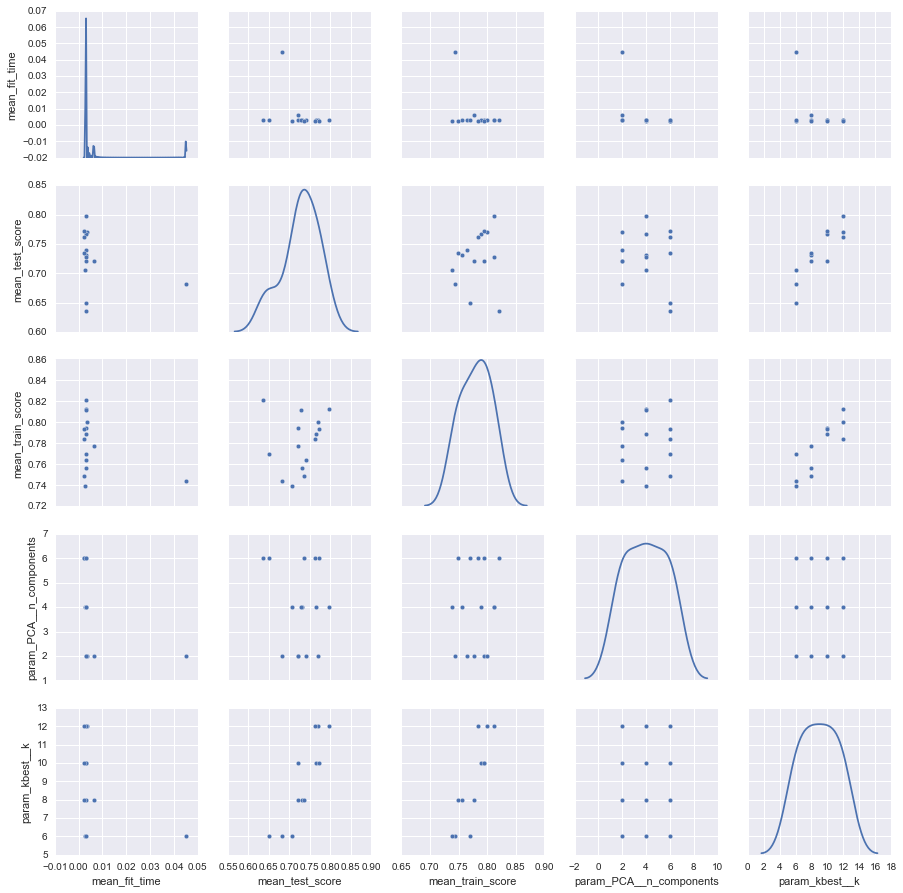

In [28]:
%matplotlib inline

sns.pairplot(models_df, diag_kind='kde', palette="husl",
             vars = ['mean_fit_time', 'mean_test_score', 'mean_train_score', 'param_PCA__n_components',
                     'param_kbest__k'])


Just wanted to explore the model parameter space a bit. There is no relationship between PCA__n_components and mean test score. This seems plausible as it's not how many components, but also what features are reduced. There does appear to be some relationship between mean test score and number of features.Perhaps having a larger number of features will allow PCA to have a larger pool of features to find the optimum mix.

In [29]:
# try pipeline w decision tree

kbest = SelectKBest(f_classif)
pca = PCA()
scaler = preprocessing.StandardScaler()
clf_DT = tree.DecisionTreeClassifier()


# read that I should normalize before PCA so I put normalizer before PCA in pipeline
# http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

pipe_DT = Pipeline(steps =[
    ('kbest', kbest),
    #('std_scale', scaler),    
    #('PCA', pca),   
    ('DT_clf', clf_DT)    
    ])

parameters_DT = {#"PCA__n_components":[2,4,6], 
                 #"PCA__whiten": [True],
                 "kbest__k":[6,8,10,12,'all'], "DT_clf__min_samples_split":[2,3,4],
                 "DT_clf__max_depth":[6,4]}

In [30]:
# use pipeline in GridSearchCV

if __name__ == "__main__":
    
    # initialize grid search
    grid_search = GridSearchCV(pipe_DT, parameters_DT, n_jobs = -1, verbose = 1, scoring = "roc_auc")
 
    print("\nPerforming grid search...")
    print("pipeline:", [name for name, _ in pipe_DT.steps])
    print("parameters:")
    #pprint(parameters)
    t0 = dt.now()
    grid_search.fit(features_train, labels_train)
    print("done in {}\n".format(dt.now() - t0))
    print("\nBest score: {:0.3f}".format(grid_search.best_score_))
    print("\nBest parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters_DT.keys()):
        print("\t{}: {}".format(param_name, best_parameters[param_name]))



Performing grid search...
('pipeline:', ['kbest', 'DT_clf'])
parameters:
Fitting 3 folds for each of 30 candidates, totalling 90 fits
done in 0:00:02.525000


Best score: 0.687

Best parameters set:
	DT_clf__max_depth: 4
	DT_clf__min_samples_split: 2
	kbest__k: 6


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished


In [31]:
features_selected_bool = grid_search.best_estimator_.named_steps['kbest'].get_support()
features_selected_list = [x for x, y in zip(features_list1[1:], features_selected_bool) if y]
features_selected_list

['salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'payments_plus_stock']

In [32]:
best_clf = grid_search.best_estimator_.fit(features_train, labels_train)

In [33]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict1 = pickle.load(data_file)

    
    
### Task 2: Remove outlier identified from earlier visualizatoin
data_dict1.pop('TOTAL')
data_dict1.pop('THE TRAVEL AGENCY IN THE PARK')


# add custom features
for name in data_dict1:
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['salary'] != 'NaN':
        data_dict1[name]['total_salary_ratio'] = (data_dict1[name]['total_payments']*1./data_dict1[name]['salary'])
    else:
        data_dict1[name]['total_salary_ratio'] = 'NaN'
    if data_dict1[name]['total_payments'] != 'NaN' and data_dict1[name]['total_stock_value'] != 'NaN':
        data_dict1[name]['payments_plus_stock'] = data_dict1[name]['total_payments'] \
        + data_dict1[name]['total_stock_value']
    else:
        data_dict1[name]['payments_plus_stock'] = 'NaN'

### Store to my_dataset for easy export below.
my_dataset1 = data_dict1
         

### Extract features and labels from dataset for local testing (use features_selected_list)
from pprint import pprint
# due to featureFormat() need to add 'poi' as first feature of the list
# https://discussions.udacity.com/t/valueerror-the-least-populated-class-in-y-has-only-1-member-which-is-too-few/44984/2
poi_first = ['poi']
features_selected_list = poi_first + features_selected_list
data1 = featureFormat(my_dataset1, features_selected_list, sort_keys = True)
labels, features = targetFeatureSplit(data1)
pprint(features_selected_list)
# pprint(labels)
# labels are now all 0.0 and 1.0 as they should be after including POI first
dump_classifier_and_data(best_clf, my_dataset1, features_selected_list)
main()

['poi',
 'salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'payments_plus_stock']
Pipeline(steps=[('kbest', SelectKBest(k=6, score_func=<function f_classif at 0x0000000007531F28>)), ('DT_clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.81857	Precision: 0.28331	Recall: 0.17650	F1: 0.21750	F2: 0.19089
	Total predictions: 14000	True positives:  353	False positives:  893	False negatives: 1647	True negatives: 11107



['poi',
 'salary',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'payments_plus_stock']
Pipeline(steps=[('kbest', SelectKBest(k=6, score_func=<function f_classif at 0x00000000075B2EB8>)), ('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('PCA', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('DT_clf',...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.79436	Precision: 0.26635	Recall: 0.25050	F1: 0.25818	F2: 0.25352
	Total predictions: 14000	True positives:  501	False positives: 1380	False negatives: 1499	True negatives: 10620

With the parameters above, I am not getting prediction metrics as high as using decision tree alone outside of a pipeline. Perhaps PCA or feature scaling is affecting signal. **NOTE** while editing code above to modify parameters of pipeline_DT, I noticed that I had not changed the parameters object to point to parameters_DT yet. So the results above are invalid and I need to rerun them with the correct parameters. 

After correction:
['poi',
 'salary',
 'total_payments',
 'bonus',
 'other',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'payments_plus_stock']
Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x0000000003E296D8>)), ('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('PCA', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('DT_clf'...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.84080	Precision: 0.25443	Recall: 0.10050	F1: 0.14409	F2: 0.11433
	Total predictions: 15000	True positives:  201	False positives:  589	False negatives: 1799	True negatives: 12411

